In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

   Strike  Option Price  Implied Volatility
0      95         10.93            0.208123
1      96          9.55            0.186236
2      97          8.28            0.167306
3      98          7.40            0.158340
4      99          6.86            0.157592
5     100          6.58            0.162762
6     101          6.52            0.172779
7     102          6.49            0.182937
8     103          6.47            0.192823
9     104          6.46            0.202511


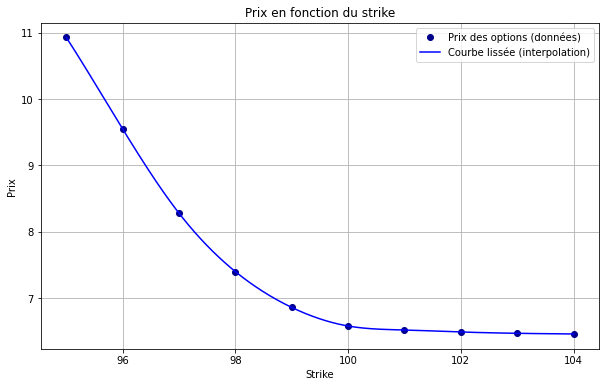

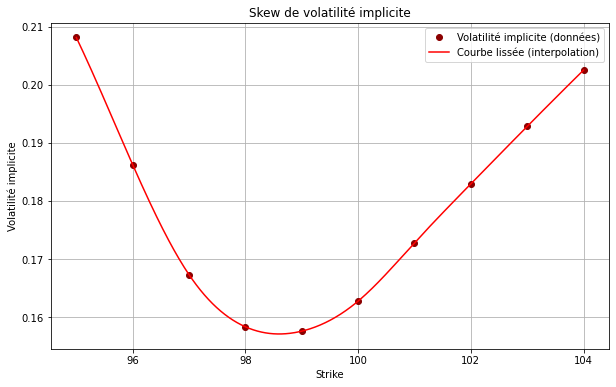

In [7]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Fonctions Black-Scholes et volatilité implicite
def black_scholes_call_price_for_IM(S, K, T, r, sigma):
    if T <= 0:
        return max(S - K, 0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def implied_vol_newton_raphson(S, K, T, r, market_price, tol=1e-6, max_iter=100):
    sigma = 0.2
    for i in range(max_iter):
        price_bs = black_scholes_call_price_for_IM(S, K, T, r, sigma)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        vega = S * norm.pdf(d1) * np.sqrt(T)
        diff = price_bs - market_price
        if abs(diff) < tol:
            return sigma
        sigma -= diff / vega
    return np.nan

# Données 
strike = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
prices = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
S = 100  
rf = 0.002  
T = 1 

# Calcul des volatilités implicites
implied_vols = []
for K, market_price in zip(strike, prices):
    iv = implied_vol_newton_raphson(S, K, T, rf, market_price)
    implied_vols.append(iv)

# Résultats
results = pd.DataFrame({"Strike": strike, "Option Price": prices, "Implied Volatility": implied_vols})
print(results)

# Interpolation pour les courbes lissées
strike_fine = np.linspace(min(strike), max(strike), 500)  # Résolution fine pour interpolation
prices_interp = interp1d(strike, prices, kind='cubic')  # Interpolation cubique pour les prix
vols_interp = interp1d(strike, implied_vols, kind='cubic')  # Interpolation cubique pour les vols

# Tracé des courbes
plt.figure(figsize=(10, 6))
plt.plot(strike, prices, 'o', color='darkblue', label='Prix des options (données)')
plt.plot(strike_fine, prices_interp(strike_fine), '-', color='blue', label='Courbe lissée (interpolation)')
plt.title('Prix en fonction du strike')
plt.xlabel('Strike')
plt.ylabel('Prix')
plt.grid()
plt.legend()

plt.figure(figsize=(10, 6))
plt.plot(strike, implied_vols, 'o', color='darkred', label='Volatilité implicite (données)')
plt.plot(strike_fine, vols_interp(strike_fine), '-', color='red', label='Courbe lissée (interpolation)')
plt.title('Skew de volatilité implicite')
plt.xlabel('Strike')
plt.ylabel('Volatilité implicite')
plt.grid()
plt.legend()

plt.show()


stress test.

modele a vol local et stochastique.

Q1) afficher P en fct de K
lisser la courbe de la vol (pq pas plusieurs fois????)
deriver fct lisse en fct de K (derivées empiriques)

ex: dC/dK= (C(K2)-C(K1))/(K2-K1)


.................................................................................
surface de vol implicite:
(on peut garder la meme maturité)
on va pouvoir generer des points pr d'autres maturités et ainsi créée une surface de vol
.................................................................................


Q2) minimiser la somme des ecart qudra entre le modele et les valeurs reelles
modele SVI (modele de surface de volatilité) page 69 du cours

parametress a estimer sont a b m sigma(ici pas vol)
puis modele svi generalisé, il faut réestimer tout le modele 
choisir le meilleur modele. (evolution des truc quadratique jsp trop)


Q3) 


Q4) fonction objectif (a raprocher de 0) f()= prix model-prix marché (pas de val absolue???)
il s'agit de changer les parametres d'une focntion precedante????

Q5) comparer visulemenet et quantitafiquement les resultats entre Q3 et Q5

Q6) stress sur l'option strike 100 (saut realiste qui respecte les conditions d'arbitrage (cours 1 et 2) bien les verifier)
ex: a partir de 7e y a une condition d'arbitrage, on prends alors 6.99
regarder donc les saut max a la hausse et a la baisse.
puis recalculer le svi et le modele de dupir de la question 5 avec les fcts precedentes
regarder comment evolue les resultats en fct des pics

Partie 2 ressemble bcp mais en vol stochastique.



Best parameters for SVI model: [ 8.36631618 -3.20528889 -4.48586733 -3.5347746   1.61862341]
Best parameters for generalized SVI model: [ 4.3351864  -2.24365892 -3.09916536 -4.16657823  0.08266183  4.51328389]


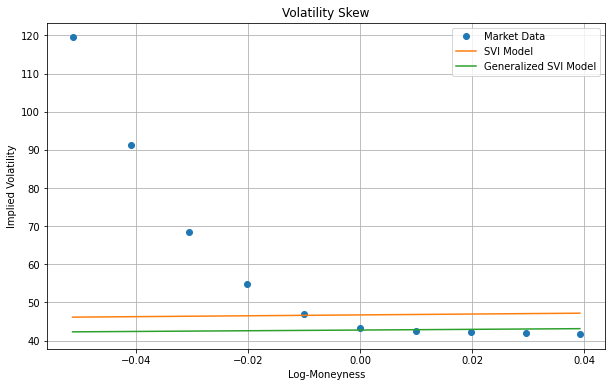

In [12]:
import numpy as np

# Define the SVI model
def svi_model(params, k):
    a, b, rho, m, sigma = params
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2))

# Define the generalized SVI model
def generalized_svi_model(params, k):
    a, b, rho, m, sigma, eta = params
    return a + b * (rho * (k - m) + np.sqrt((k - m)**2 + sigma**2)) + eta * (k - m)

# Objective function to minimize
def objective_function(params, k, w, model):
    return np.sum((model(params, k) - w)**2)

# Nelder-Mead algorithm
def nelder_mead(func, initial_params, args=(), tol=1e-6, max_iter=1000):
    n = len(initial_params)
    simplex = np.zeros((n + 1, n))
    simplex[0] = initial_params
    for i in range(n):
        x = np.copy(initial_params)
        x[i] += 0.05
        simplex[i + 1] = x

    for _ in range(max_iter):
        simplex = sorted(simplex, key=lambda x: func(x, *args))
        if np.std([func(x, *args) for x in simplex]) < tol:
            break
        
        centroid = np.mean(simplex[:-1], axis=0)
        reflected = centroid + (centroid - simplex[-1])
        if func(reflected, *args) < func(simplex[-2], *args):
            simplex[-1] = reflected
        else:
            contracted = centroid + 0.5 * (simplex[-1] - centroid)
            if func(contracted, *args) < func(simplex[-1], *args):
                simplex[-1] = contracted
            else:
                for i in range(1, len(simplex)):
                    simplex[i] = simplex[0] + 0.5 * (simplex[i] - simplex[0])

    return simplex[0]

# Initial parameters
initial_params_svi = [0.01, 0.1, -0.5, 0, 0.1]
initial_params_generalized_svi = [0.01, 0.1, -0.5, 0, 0.1, 0.1]

# Fit SVI model
best_params_svi = nelder_mead(objective_function, initial_params_svi, args=(k, w, svi_model))
print("Best parameters for SVI model:", best_params_svi)

# Fit generalized SVI model
best_params_generalized_svi = nelder_mead(objective_function, initial_params_generalized_svi, args=(k, w, generalized_svi_model))
print("Best parameters for generalized SVI model:", best_params_generalized_svi)

# Calculate the volatility skew
vols_svi = svi_model(best_params_svi, k_fine)
vols_generalized_svi = generalized_svi_model(best_params_generalized_svi, k_fine)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k, w, 'o', label='Market Data')
plt.plot(k_fine, vols_svi, label='SVI Model')
plt.plot(k_fine, vols_generalized_svi, label='Generalized SVI Model')
plt.xlabel('Log-Moneyness')
plt.ylabel('Implied Volatility')
plt.title('Volatility Skew')
plt.legend()
plt.grid()
plt.show()